# Reinforcement Learning Agent for Hangman

This notebook implements the RL component that uses the HMM to make intelligent letter guessing decisions.

## Approach:
- **State**: Masked word, guessed letters, lives remaining, HMM probability distribution
- **Actions**: Guess any unguessed letter
- **Reward**: Designed to maximize wins and minimize wrong/repeated guesses
- **Algorithm**: Q-Learning with function approximation

In [8]:
import numpy as np
import pickle
import random
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set_style('whitegrid')
%matplotlib inline

## 1. Load the HMM Model

In [9]:
# Import the PositionalHMM class definition (needed for unpickling)
from collections import Counter

class PositionalHMM:
    """A simplified HMM using positional letter frequencies"""
    
    def __init__(self):
        self.letter_freq_by_length = {}
        self.overall_freq_by_length = {}
        self.word_list_by_length = {}
        self.all_letters = set('abcdefghijklmnopqrstuvwxyz')
        
    def train(self, corpus):
        """Train the model on the corpus"""
        print("Training Positional HMM...")
        
        for word in corpus:
            word = word.lower()
            length = len(word)
            
            # Initialize if needed
            if length not in self.word_list_by_length:
                self.word_list_by_length[length] = []
                self.letter_freq_by_length[length] = {}
                self.overall_freq_by_length[length] = Counter()
            
            self.word_list_by_length[length].append(word)
            
            # Track positional frequencies
            for pos, letter in enumerate(word):
                if pos not in self.letter_freq_by_length[length]:
                    self.letter_freq_by_length[length][pos] = Counter()
                self.letter_freq_by_length[length][pos][letter] += 1
                self.overall_freq_by_length[length][letter] += 1
        
        print(f"Training complete! Learned patterns for {len(self.letter_freq_by_length)} different word lengths.")
    
    def get_letter_probabilities(self, masked_word, guessed_letters):
        """
        Given a masked word (e.g., '_pp__') and guessed letters,
        return probability distribution over remaining letters
        """
        length = len(masked_word)
        remaining_letters = self.all_letters - set(guessed_letters)
        
        if length not in self.word_list_by_length:
            # Fallback to overall English letter frequency
            return self._get_default_probabilities(remaining_letters)
        
        # Filter words matching the pattern
        matching_words = self._get_matching_words(masked_word, guessed_letters, length)
        
        if not matching_words:
            # Use positional frequencies as fallback
            return self._get_positional_probabilities(masked_word, remaining_letters, length)
        
        # Count letter frequencies in matching words
        letter_counts = Counter()
        for word in matching_words:
            for letter in set(word):
                if letter in remaining_letters:
                    letter_counts[letter] += 1
        
        # Convert to probabilities
        total = sum(letter_counts.values())
        if total == 0:
            return self._get_default_probabilities(remaining_letters)
        
        probabilities = {letter: count / total for letter, count in letter_counts.items()}
        
        # Add small probability for unobserved letters
        for letter in remaining_letters:
            if letter not in probabilities:
                probabilities[letter] = 1e-6
        
        return probabilities
    
    def _get_matching_words(self, masked_word, guessed_letters, length):
        """Find words matching the current pattern"""
        matching_words = []
        
        for word in self.word_list_by_length[length]:
            # Check if word matches the pattern
            if self._matches_pattern(word, masked_word, guessed_letters):
                matching_words.append(word)
        
        return matching_words
    
    def _matches_pattern(self, word, masked_word, guessed_letters):
        """Check if a word matches the masked pattern"""
        if len(word) != len(masked_word):
            return False
        
        for i, (w_char, m_char) in enumerate(zip(word, masked_word)):
            if m_char != '_':
                if w_char != m_char:
                    return False
            else:
                # This position is masked, ensure it wasn't guessed
                if w_char in guessed_letters:
                    return False
        
        return True
    
    def _get_positional_probabilities(self, masked_word, remaining_letters, length):
        """Get probabilities based on positional frequencies"""
        letter_scores = defaultdict(float)
        
        for pos, char in enumerate(masked_word):
            if char == '_':
                if pos in self.letter_freq_by_length[length]:
                    pos_freq = self.letter_freq_by_length[length][pos]
                    total = sum(pos_freq.values())
                    if total > 0:
                        for letter in remaining_letters:
                            letter_scores[letter] += pos_freq[letter] / total
        
        total_score = sum(letter_scores.values())
        if total_score == 0:
            return self._get_default_probabilities(remaining_letters)
        
        return {letter: score / total_score for letter, score in letter_scores.items()}
    
    def _get_default_probabilities(self, remaining_letters):
        """Default English letter frequencies"""
        default_freq = {
            'e': 0.127, 't': 0.091, 'a': 0.082, 'o': 0.075, 'i': 0.070,
            'n': 0.067, 's': 0.063, 'h': 0.061, 'r': 0.060, 'd': 0.043,
            'l': 0.040, 'c': 0.028, 'u': 0.028, 'm': 0.024, 'w': 0.024,
            'f': 0.022, 'g': 0.020, 'y': 0.020, 'p': 0.019, 'b': 0.015,
            'v': 0.010, 'k': 0.008, 'j': 0.002, 'x': 0.002, 'q': 0.001, 'z': 0.001
        }
        
        probabilities = {}
        for letter in remaining_letters:
            probabilities[letter] = default_freq.get(letter, 1e-6)
        
        total = sum(probabilities.values())
        return {letter: prob / total for letter, prob in probabilities.items()}

In [10]:
# Load the trained HMM
with open('hmm_model.pkl', 'rb') as f:
    hmm = pickle.load(f)

print("HMM model loaded successfully!")

HMM model loaded successfully!


## 2. Build the Hangman Environment

In [11]:
class HangmanEnvironment:
    """Hangman game environment for RL agent"""
    
    def __init__(self, word_list, max_lives=6):
        self.word_list = word_list
        self.max_lives = max_lives
        self.reset()
    
    def reset(self, word=None):
        """Reset the environment for a new game"""
        if word is None:
            self.target_word = random.choice(self.word_list).lower()
        else:
            self.target_word = word.lower()
        
        self.lives = self.max_lives
        self.guessed_letters = set()
        self.masked_word = '_' * len(self.target_word)
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.done = False
        
        return self.get_state()
    
    def get_state(self):
        """Get current state representation"""
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'lives': self.lives,
            'word_length': len(self.target_word),
            'done': self.done
        }
    
    def step(self, letter):
        """Take an action (guess a letter) and return reward and next state"""
        letter = letter.lower()
        reward = 0
        
        # Check for repeated guess
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -5  # Heavy penalty for repeated guess
            return self.get_state(), reward, self.done
        
        self.guessed_letters.add(letter)
        
        # Check if letter is in the word
        if letter in self.target_word:
            # Correct guess - update masked word
            new_masked = list(self.masked_word)
            count = 0
            for i, char in enumerate(self.target_word):
                if char == letter:
                    new_masked[i] = letter
                    count += 1
            self.masked_word = ''.join(new_masked)
            
            # Reward based on number of letters revealed
            reward = 2 * count  # More letters revealed = higher reward
            
            # Check if word is complete
            if '_' not in self.masked_word:
                reward += 50  # Big bonus for winning
                self.done = True
        else:
            # Wrong guess
            self.lives -= 1
            self.wrong_guesses += 1
            reward = -10  # Penalty for wrong guess
            
            # Check if game over
            if self.lives <= 0:
                reward = -30  # Heavy penalty for losing
                self.done = True
        
        return self.get_state(), reward, self.done
    
    def get_valid_actions(self):
        """Get list of valid actions (unguessed letters)"""
        all_letters = set('abcdefghijklmnopqrstuvwxyz')
        return list(all_letters - self.guessed_letters)

## 3. Build the RL Agent

In [12]:
class HangmanQLearningAgent:
    """Q-Learning agent that uses HMM probabilities to make decisions"""
    
    def __init__(self, hmm_model, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.hmm = hmm_model
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Q-table: We'll use a simplified state representation
        self.q_table = defaultdict(lambda: defaultdict(float))
        
        # Statistics
        self.training_rewards = []
        self.training_wins = []
        self.training_wrong_guesses = []
    
    def get_state_key(self, state):
        """Convert state to a hashable key for Q-table"""
        # Simplified state: (masked_word_pattern, lives, num_guessed)
        pattern = state['masked_word']
        lives = state['lives']
        num_guessed = len(state['guessed_letters'])
        return (pattern, lives, num_guessed)
    
    def get_action(self, state, valid_actions, training=True):
        """Select an action using epsilon-greedy policy with HMM guidance"""
        # Get HMM probabilities
        hmm_probs = self.hmm.get_letter_probabilities(
            state['masked_word'], 
            state['guessed_letters']
        )
        
        # Exploration: random action weighted by HMM probabilities
        if training and random.random() < self.epsilon:
            # Weighted random choice based on HMM probabilities
            valid_probs = {letter: hmm_probs.get(letter, 1e-6) for letter in valid_actions}
            total = sum(valid_probs.values())
            probabilities = [valid_probs[letter] / total for letter in valid_actions]
            return np.random.choice(valid_actions, p=probabilities)
        
        # Exploitation: choose action with highest Q-value + HMM probability
        state_key = self.get_state_key(state)
        action_values = {}
        
        for action in valid_actions:
            q_value = self.q_table[state_key][action]
            hmm_prob = hmm_probs.get(action, 1e-6)
            # Combine Q-value with HMM probability (weighted sum)
            action_values[action] = q_value + 10 * hmm_prob  # Weight HMM influence
        
        return max(action_values, key=action_values.get)
    
    def update_q_value(self, state, action, reward, next_state, done):
        """Update Q-value using Q-learning update rule"""
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)
        
        # Current Q-value
        current_q = self.q_table[state_key][action]
        
        # Maximum Q-value for next state
        if done:
            max_next_q = 0
        else:
            next_q_values = self.q_table[next_state_key].values()
            max_next_q = max(next_q_values) if next_q_values else 0
        
        # Q-learning update
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state_key][action] = new_q
    
    def train(self, env, num_episodes=5000, verbose=True):
        """Train the agent"""
        print(f"Training agent for {num_episodes} episodes...")
        
        for episode in tqdm(range(num_episodes)):
            state = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                # Get valid actions
                valid_actions = env.get_valid_actions()
                
                # Select action
                action = self.get_action(state, valid_actions, training=True)
                
                # Take action
                next_state, reward, done = env.step(action)
                
                # Update Q-value
                self.update_q_value(state, action, reward, next_state, done)
                
                total_reward += reward
                state = next_state
            
            # Record statistics
            self.training_rewards.append(total_reward)
            self.training_wins.append(1 if '_' not in state['masked_word'] else 0)
            self.training_wrong_guesses.append(env.wrong_guesses)
            
            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
            # Periodic logging
            if verbose and (episode + 1) % 500 == 0:
                recent_wins = sum(self.training_wins[-500:])
                recent_avg_reward = np.mean(self.training_rewards[-500:])
                recent_avg_wrong = np.mean(self.training_wrong_guesses[-500:])
                print(f"\nEpisode {episode + 1}/{num_episodes}")
                print(f"  Win Rate (last 500): {recent_wins/500:.2%}")
                print(f"  Avg Reward: {recent_avg_reward:.2f}")
                print(f"  Avg Wrong Guesses: {recent_avg_wrong:.2f}")
                print(f"  Epsilon: {self.epsilon:.4f}")
        
        print("\nTraining complete!")
    
    def save(self, filename):
        """Save the trained agent"""
        data = {
            'q_table': dict(self.q_table),
            'epsilon': self.epsilon,
            'training_rewards': self.training_rewards,
            'training_wins': self.training_wins,
            'training_wrong_guesses': self.training_wrong_guesses
        }
        with open(filename, 'wb') as f:
            pickle.dump(data, f)
        print(f"Agent saved to {filename}")
    
    def load(self, filename):
        """Load a trained agent"""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        self.q_table = defaultdict(lambda: defaultdict(float), data['q_table'])
        self.epsilon = data['epsilon']
        self.training_rewards = data['training_rewards']
        self.training_wins = data['training_wins']
        self.training_wrong_guesses = data['training_wrong_guesses']
        print(f"Agent loaded from {filename}")

## 4. Load Corpus for Training

In [13]:
# Load corpus
with open('Data/Data/corpus.txt', 'r') as f:
    corpus = [line.strip().lower() for line in f if line.strip()]

print(f"Loaded {len(corpus)} words for training")

Loaded 50000 words for training


## 5. Initialize Environment and Agent

In [14]:
# Create environment
env = HangmanEnvironment(corpus, max_lives=6)

# Create agent
agent = HangmanQLearningAgent(
    hmm_model=hmm,
    alpha=0.1,          # Learning rate
    gamma=0.95,         # Discount factor
    epsilon=1.0,        # Initial exploration rate
    epsilon_decay=0.9995,  # Slower decay for better exploration
    epsilon_min=0.05    # Minimum exploration
)

print("Environment and Agent initialized!")

Environment and Agent initialized!


## 6. Train the Agent

In [15]:
# Train the agent
agent.train(env, num_episodes=10000, verbose=True)

Training agent for 10000 episodes...


  5%|▌         | 501/10000 [00:44<15:33, 10.18it/s]


Episode 500/10000
  Win Rate (last 500): 89.40%
  Avg Reward: 35.18
  Avg Wrong Guesses: 2.54
  Epsilon: 0.7788


 10%|█         | 1002/10000 [01:28<11:33, 12.97it/s]


Episode 1000/10000
  Win Rate (last 500): 92.40%
  Avg Reward: 40.41
  Avg Wrong Guesses: 2.27
  Epsilon: 0.6065


 15%|█▌        | 1501/10000 [02:11<13:24, 10.57it/s]


Episode 1500/10000
  Win Rate (last 500): 90.80%
  Avg Reward: 37.66
  Avg Wrong Guesses: 2.44
  Epsilon: 0.4723


 20%|██        | 2001/10000 [02:52<13:28,  9.90it/s]


Episode 2000/10000
  Win Rate (last 500): 91.40%
  Avg Reward: 39.70
  Avg Wrong Guesses: 2.22
  Epsilon: 0.3678


 25%|██▌       | 2501/10000 [03:38<16:39,  7.50it/s]


Episode 2500/10000
  Win Rate (last 500): 91.20%
  Avg Reward: 41.02
  Avg Wrong Guesses: 2.08
  Epsilon: 0.2864


 30%|███       | 3001/10000 [04:42<13:56,  8.37it/s]


Episode 3000/10000
  Win Rate (last 500): 94.20%
  Avg Reward: 46.98
  Avg Wrong Guesses: 1.81
  Epsilon: 0.2230


 35%|███▌      | 3503/10000 [05:37<06:24, 16.91it/s]


Episode 3500/10000
  Win Rate (last 500): 95.20%
  Avg Reward: 47.33
  Avg Wrong Guesses: 1.77
  Epsilon: 0.1737


 40%|████      | 4001/10000 [06:40<12:17,  8.13it/s]


Episode 4000/10000
  Win Rate (last 500): 93.40%
  Avg Reward: 47.16
  Avg Wrong Guesses: 1.71
  Epsilon: 0.1353


 45%|████▌     | 4501/10000 [07:41<09:28,  9.67it/s]


Episode 4500/10000
  Win Rate (last 500): 93.80%
  Avg Reward: 47.89
  Avg Wrong Guesses: 1.63
  Epsilon: 0.1053


 50%|█████     | 5001/10000 [08:43<09:57,  8.37it/s]


Episode 5000/10000
  Win Rate (last 500): 94.80%
  Avg Reward: 47.94
  Avg Wrong Guesses: 1.70
  Epsilon: 0.0820


 55%|█████▌    | 5501/10000 [09:45<08:19,  9.00it/s]


Episode 5500/10000
  Win Rate (last 500): 95.60%
  Avg Reward: 49.53
  Avg Wrong Guesses: 1.61
  Epsilon: 0.0639


 60%|██████    | 6002/10000 [10:49<07:50,  8.50it/s]


Episode 6000/10000
  Win Rate (last 500): 94.40%
  Avg Reward: 48.06
  Avg Wrong Guesses: 1.65
  Epsilon: 0.0500


 65%|██████▌   | 6501/10000 [11:52<08:55,  6.53it/s]


Episode 6500/10000
  Win Rate (last 500): 94.20%
  Avg Reward: 48.41
  Avg Wrong Guesses: 1.64
  Epsilon: 0.0500


 70%|███████   | 7001/10000 [12:59<06:37,  7.55it/s]


Episode 7000/10000
  Win Rate (last 500): 95.20%
  Avg Reward: 49.53
  Avg Wrong Guesses: 1.63
  Epsilon: 0.0500


 75%|███████▌  | 7501/10000 [13:40<04:14,  9.82it/s]


Episode 7500/10000
  Win Rate (last 500): 95.00%
  Avg Reward: 47.78
  Avg Wrong Guesses: 1.73
  Epsilon: 0.0500


 80%|████████  | 8002/10000 [14:19<01:36, 20.61it/s]


Episode 8000/10000
  Win Rate (last 500): 94.20%
  Avg Reward: 47.24
  Avg Wrong Guesses: 1.73
  Epsilon: 0.0500


 85%|████████▌ | 8500/10000 [14:46<02:25, 10.31it/s]


Episode 8500/10000
  Win Rate (last 500): 97.40%
  Avg Reward: 52.63
  Avg Wrong Guesses: 1.46
  Epsilon: 0.0500


 90%|█████████ | 9002/10000 [15:44<01:05, 15.31it/s]


Episode 9000/10000
  Win Rate (last 500): 96.00%
  Avg Reward: 48.18
  Avg Wrong Guesses: 1.76
  Epsilon: 0.0500


 95%|█████████▌| 9501/10000 [16:40<01:01,  8.18it/s]


Episode 9500/10000
  Win Rate (last 500): 95.80%
  Avg Reward: 50.69
  Avg Wrong Guesses: 1.53
  Epsilon: 0.0500


100%|██████████| 10000/10000 [17:42<00:00,  9.41it/s]


Episode 10000/10000
  Win Rate (last 500): 96.40%
  Avg Reward: 50.82
  Avg Wrong Guesses: 1.56
  Epsilon: 0.0500

Training complete!


## 7. Visualize Training Progress

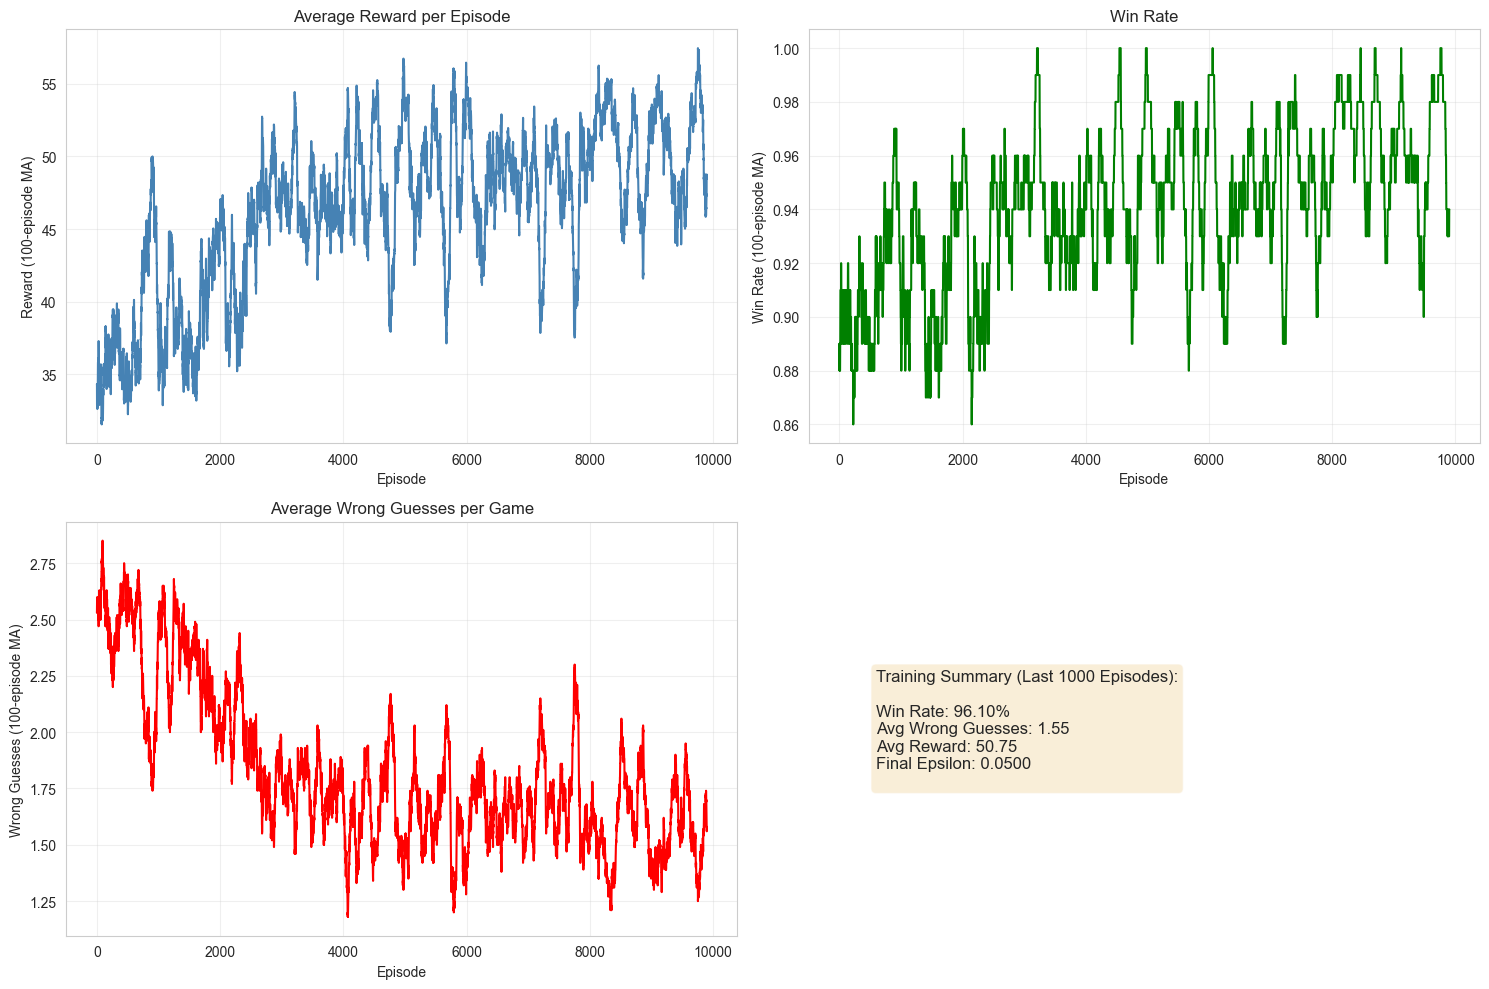


Final Training Statistics:
Training Summary (Last 1000 Episodes):

Win Rate: 96.10%
Avg Wrong Guesses: 1.55
Avg Reward: 50.75
Final Epsilon: 0.0500



In [16]:
# Plot training metrics
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rewards
axes[0, 0].plot(moving_average(agent.training_rewards, 100), color='steelblue')
axes[0, 0].set_title('Average Reward per Episode')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward (100-episode MA)')
axes[0, 0].grid(alpha=0.3)

# Win rate
win_rate = moving_average(agent.training_wins, 100)
axes[0, 1].plot(win_rate, color='green')
axes[0, 1].set_title('Win Rate')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Win Rate (100-episode MA)')
axes[0, 1].grid(alpha=0.3)

# Wrong guesses
axes[1, 0].plot(moving_average(agent.training_wrong_guesses, 100), color='red')
axes[1, 0].set_title('Average Wrong Guesses per Game')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Wrong Guesses (100-episode MA)')
axes[1, 0].grid(alpha=0.3)

# Overall statistics
total_episodes = len(agent.training_wins)
final_win_rate = sum(agent.training_wins[-1000:]) / 1000
final_avg_wrong = np.mean(agent.training_wrong_guesses[-1000:])
final_avg_reward = np.mean(agent.training_rewards[-1000:])

stats_text = f"""Training Summary (Last 1000 Episodes):

Win Rate: {final_win_rate:.2%}
Avg Wrong Guesses: {final_avg_wrong:.2f}
Avg Reward: {final_avg_reward:.2f}
Final Epsilon: {agent.epsilon:.4f}
"""

axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\nFinal Training Statistics:")
print(stats_text)

## 8. Test the Agent on Sample Words

In [17]:
# Test the agent on a few words
test_words = ['python', 'machine', 'learning', 'algorithm', 'neural']

for word in test_words:
    print(f"\n{'='*50}")
    print(f"Target word: {word}")
    print('='*50)
    
    state = env.reset(word)
    done = False
    step = 0
    
    while not done:
        step += 1
        valid_actions = env.get_valid_actions()
        action = agent.get_action(state, valid_actions, training=False)
        
        print(f"\nStep {step}: {state['masked_word']} | Lives: {state['lives']}")
        print(f"Guessed: {sorted(state['guessed_letters'])}")
        print(f"Agent guesses: '{action}'")
        
        state, reward, done = env.step(action)
        print(f"Reward: {reward}")
    
    print(f"\nFinal: {state['masked_word']} | Lives: {state['lives']}")
    if '_' not in state['masked_word']:
        print("✓ WON!")
    else:
        print("✗ LOST!")
    print(f"Wrong guesses: {env.wrong_guesses}")
    print(f"Repeated guesses: {env.repeated_guesses}")


Target word: python

Step 1: ______ | Lives: 6
Guessed: []
Agent guesses: 'o'
Reward: 2

Step 2: ____o_ | Lives: 6
Guessed: ['o']
Agent guesses: 'n'
Reward: 2

Step 3: ____on | Lives: 6
Guessed: ['n', 'o']
Agent guesses: 'a'
Reward: -10

Step 4: ____on | Lives: 5
Guessed: ['a', 'n', 'o']
Agent guesses: 't'
Reward: 2

Step 5: __t_on | Lives: 5
Guessed: ['a', 'n', 'o', 't']
Agent guesses: 'p'
Reward: 2

Step 6: p_t_on | Lives: 5
Guessed: ['a', 'n', 'o', 'p', 't']
Agent guesses: 'h'
Reward: 2

Step 7: p_thon | Lives: 5
Guessed: ['a', 'h', 'n', 'o', 'p', 't']
Agent guesses: 'w'
Reward: -10

Step 8: p_thon | Lives: 4
Guessed: ['a', 'h', 'n', 'o', 'p', 't', 'w']
Agent guesses: 'r'
Reward: -10

Step 9: p_thon | Lives: 3
Guessed: ['a', 'h', 'n', 'o', 'p', 'r', 't', 'w']
Agent guesses: 'e'
Reward: -10

Step 10: p_thon | Lives: 2
Guessed: ['a', 'e', 'h', 'n', 'o', 'p', 'r', 't', 'w']
Agent guesses: 'i'
Reward: -10

Step 11: p_thon | Lives: 1
Guessed: ['a', 'e', 'h', 'i', 'n', 'o', 'p', 'r', 't'

## 9. Save the Trained Agent

In [18]:
# Save the trained agent
agent.save('rl_agent.pkl')
print("\nRL Agent training complete!")

Agent saved to rl_agent.pkl

RL Agent training complete!


## Summary

The RL agent has been successfully trained! Key features:

1. **Hybrid Decision Making**: Combines Q-learning with HMM probability guidance
2. **Intelligent Exploration**: Uses HMM probabilities to weight exploration
3. **Reward Shaping**: 
   - +50 for winning
   - +2 per letter revealed (correct guess)
   - -10 for wrong guess
   - -30 for losing
   - -5 for repeated guess
4. **Adaptive Learning**: Epsilon-greedy policy with decay for balanced exploration/exploitation